In [1]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import math
import scipy.stats
from statsmodels.stats import weightstats
import matplotlib.mlab as mlab
from pymc.Matplot import plot as mcplot

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## transfer some data into a form we can work with
class Sample:
    def __init__(self, samples, mean):
        self.samples = samples
        self.mean = mean
        self.successes = int(round(samples * mean))
        self.failures = int(round(samples * (1-mean)))
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations)
        
    @classmethod
    def from_success_failure(self, successes, failures):
        self.samples = successes + failures
        self.successes = successes
        self.failures = failures
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations) # inplace
        self.mean = np.mean(self.observations)
        
class BaysianSummary:
    def __init__(self, trace):
        self.trace = trace
        self.data = trace[:]
        self.posterior_mean = self.data.mean()
        self.posterior_5th  = np.percentile(self.data, 5)
        self.posterior_95th  = np.percentile(self.data, 95)
        self.p_better_than = (self.data < 0).mean()
        self.p_worse_than = (self.data > 0).mean()
        
class FrequentistSummary:
    def __init__(self, delta, p):
        self.delta = delta
        self.p = p

In [12]:
control_means = [0.1]
n_samples = [100000]
variant_means = [0.101, 0.103, 0.11]

sample_pairs = [(Sample(muC, samples), Sample(muV, samples))
                for muC in control_means
                for muV in variant_means
                for samples in n_samples]

# control = Sample(10000, 0.1151)
# caption_overlay = Sample(10000, 0.1182)
# caption_larger_text = Sample(10000, 0.1161)

outputs = [BaysianSummary(run_bayes(sample1, sample2)) for (sample1, sample2) in sample_pairs]

outputs

 [-----------------100%-----------------] 20000 of 20000 complete in 16.1 sec

[<__main__.BaysianSummary instance at 0x7f1bacd5bc68>,
 <__main__.BaysianSummary instance at 0x7f1bacfa0ab8>,
 <__main__.BaysianSummary instance at 0x7f1bacf5e8c0>]

In [4]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
def run_bayes(sample1, sample2):

    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)


    # Define the deterministic delta function. This is our unknown of interest.
    @pm.deterministic
    def delta(p_A=p_A, p_B=p_B):
        return p_A - p_B

    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, value=control.observations, observed=True)
    obs_B = pm.Bernoulli("obs_B", p_B, value=caption_overlay.observations, observed=True)

    model = pm.Model([p_A, p_B, delta, obs_A, obs_B])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(20000, 1000)
    
    return mcmc.trace("delta")

In [5]:
figsize(12.5, 10)

delta_samples = run_bayes(control, caption_overlay)
summary = BaysianSummary(delta_samples)

 [-----------------100%-----------------] 20000 of 20000 complete in 52.6 sec

/usr/local/lib/python2.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


In [6]:
summary.posterior_mean

-0.0031104784810600705

Plotting delta


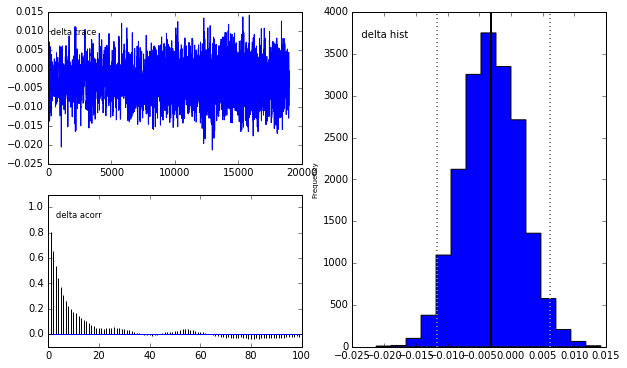

In [7]:
mcplot(summary.trace)

In [8]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability A is WORSE than B: %.3f" % \
    (summary.data < 0).mean()

print "Probability A is BETTER than B: %.3f" % \
    (summary.data > 0).mean()

Probability A is WORSE than B: 0.741
Probability A is BETTER than B: 0.259


In [9]:
def frequentist_from_samples(sample1, sample2):
    mu1 = sample1.observations.mean()
    mu2 = sample2.observations.mean()
    SE1 = mu1 * (1-mu1) / math.sqrt(len(sample1.observations))
    SE2 = mu2 * (1-mu2) / math.sqrt(len(sample2.observations))
    z = (mu1 - mu2) / (SE1**2 + SE2**2)**0.5
    p = scipy.stats.norm.sf(abs(z))*2
    delta = mu1 - mu2
    return FrequentistSummary(delta, p)

In [10]:
frequentist_from_samples(control, caption_overlay).delta

-0.0031000000000000055